In [1]:
import pandas as pd

# Load CSV file
df = pd.read_csv(r"C:\Users\Muskan\Documents\fast-api_auth\AI_policy_data.csv")

# Combine multiple text columns for NLP
df['text_for_nlp'] = (
    df['scheme_name'].astype(str) + " " +
    df['details'].astype(str) + " " +
    df['benefits'].astype(str) + " " +
    df['eligibility'].astype(str) + " " +
    df['application'].astype(str) + " " +
    df['documents'].astype(str)
).str.lower()

In [4]:
# ----------------- TF-IDF Vectorization -----------------
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df["text_for_nlp"])

# Save vectorizer and matrix
joblib.dump(vectorizer, "policy_vectorizer.pkl")
joblib.dump({"matrix": tfidf_matrix, "df": df}, "policy_matrix.pkl")

['policy_matrix.pkl']

In [5]:
# ----------------- Cosine Similarity Search -----------------
from sklearn.metrics.pairwise import cosine_similarity
import joblib

# Load saved vectorizer and matrix
vectorizer = joblib.load(r"policy_vectorizer.pkl")
data = joblib.load(r"policy_matrix.pkl")
tfidf_matrix = data["matrix"]
df = data["df"]

def query_scheme(question, top_k=3):
    query_vec = vectorizer.transform([question.lower()])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_idx = sims.argsort()[::-1][:top_k]

    results = []
    for idx in top_idx:
        row = df.iloc[idx]
        results.append({
            "scheme_name": row["scheme_name"],
            "benefits": row["benefits"],
            "eligibility": row["eligibility"],
            "similarity": float(sims[idx])
        })
    return results


# ----------------- Example Usage -----------------
question = "scholarship for students"
results = query_scheme(question, top_k=3)

if results:
    for i, res in enumerate(results, 1):
        print(f"{i}. {res['scheme_name']} | {res['similarity']:.2f}")
        print(f" Benefits: {res['benefits']}")
        print(f" Eligibility: {res['eligibility']}\n")
else:
    print("No relevant scheme found.")

1. State Merit Scholarship Manipur | 0.60
 Benefits: For Class X passed students: The scholarship provides Rs. 6,000 per annum to the first 300 students who passed the High School Leaving Certificate Examination (HSLC) conducted by BSEM for a period of two years. For Class XII passed students: The scholarship provides Rs. 12,000 per annum to the first 125 students of Science, 125 students of Social Sciences, and 50 students of Commerce who passed the class XII examination conducted by COHSEM for a period of three years. The scholarship is available to students who continue their studies within or outside the state but within the country, starting from the academic session of 2015-16. The scholarship aims to provide equal opportunities for higher education to deserving students, regardless of their economic background. In addition to the initial list of recipients, 50 students will be kept on the waiting list for possible refusal, ineligibility, or other students getting other scholarsh

In [6]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


TF-IDF matrix shape: (3400, 21205), Sparsity: 0.82%
Top 20 words/phrases by TF-IDF importance:
step: 233.76
scheme: 170.03
applicant: 166.11
application: 158.44
click: 146.01
certificate: 105.75
registration: 102.65
form: 99.42
construction: 97.03
assistance: 94.26
000: 87.93
students: 87.77
welfare: 87.72
worker: 85.50
card: 83.62
details: 77.46
documents: 76.62
workers: 76.49
financial: 74.65
government: 73.58


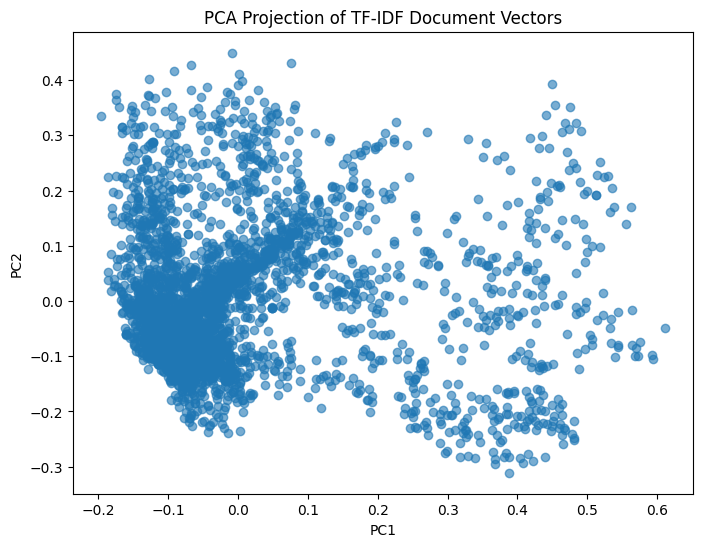

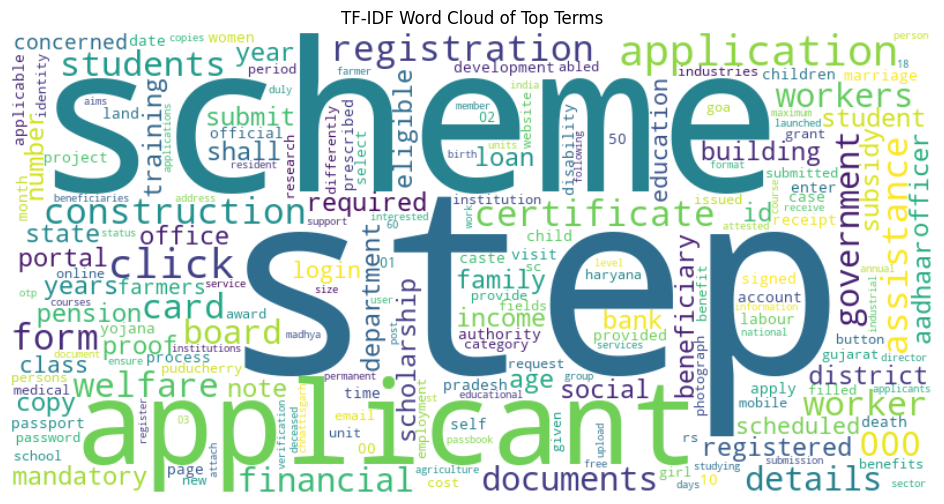

In [7]:
# ----------------- Imports -----------------
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# ----------------- Load TF-IDF Vectorizer and Matrix -----------------
vectorizer = joblib.load(r"policy_vectorizer.pkl")
data = joblib.load(r"policy_matrix.pkl")
tfidf_matrix = data["matrix"]
df = data["df"]

# ----------------- TF-IDF Matrix Analysis -----------------

# 1. Sparsity
sparsity = 100.0 * (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}, Sparsity: {sparsity:.2f}%")

# 2. Top 20 words in vocabulary by TF-IDF importance
feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[::-1][:20]

print("Top 20 words/phrases by TF-IDF importance:")
for word, score in zip(feature_names[top_indices], tfidf_sum[top_indices]):
    print(f"{word}: {score:.2f}")

# 3. PCA projection (2D) of document vectors
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
plt.title("PCA Projection of TF-IDF Document Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
# 4. Word Cloud of TF-IDF top terms
top_words_dict = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of Top Terms")
plt.show()

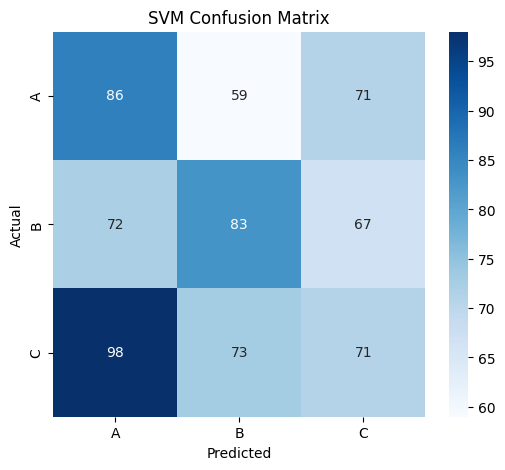

Classification Report:

              precision    recall  f1-score   support

           A       0.34      0.40      0.36       216
           B       0.39      0.37      0.38       222
           C       0.34      0.29      0.31       242

    accuracy                           0.35       680
   macro avg       0.35      0.36      0.35       680
weighted avg       0.35      0.35      0.35       680



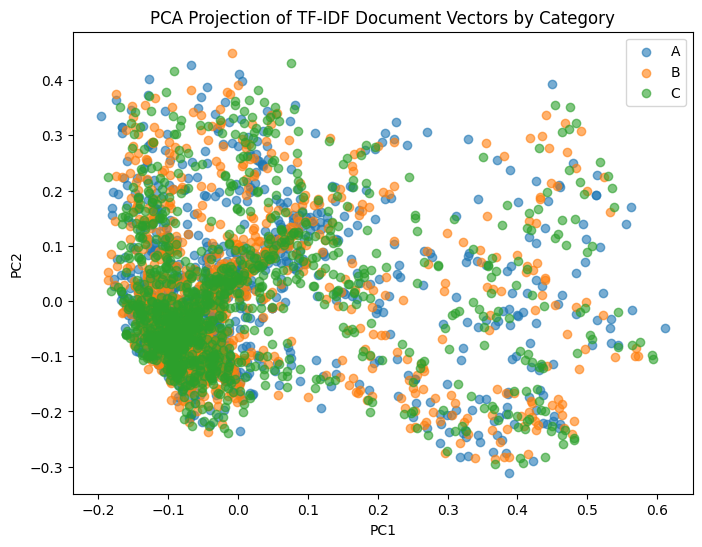

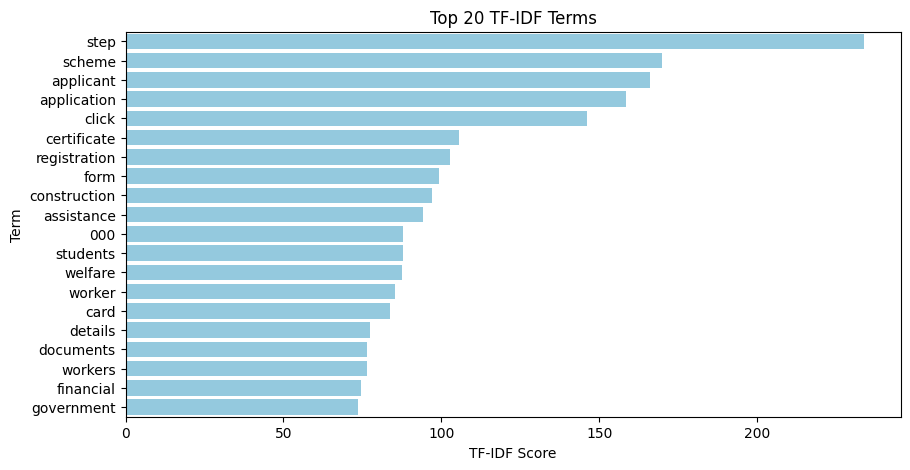

In [8]:
# ----------------- Imports -----------------
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

# ----------------- Load TF-IDF Vectorizer and Matrix -----------------
vectorizer = joblib.load(r"scheme_vectorizer.pkl")
data = joblib.load(r"scheme_tfidf_matrix.pkl")
tfidf_matrix = data["matrix"]
df = data["df"]

# ----------------- Create labels (for example) -----------------
# Assume df has a column 'category'. If not, create dummy labels for demo:
if "category" not in df.columns:
    df["category"] = np.random.choice(["A", "B", "C"], size=len(df))

y = df["category"]

# ----------------- Train-Test Split -----------------
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

# ----------------- Train SVM Classifier -----------------
svm_model = SVC(kernel='linear', probability=True)  # Linear kernel
svm_model.fit(X_train, y_train)

# ----------------- Predictions -----------------
y_pred = svm_model.predict(X_test)

# ----------------- Confusion Matrix -----------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()
# ----------------- Classification Report -----------------
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# ----------------- PCA 2D Projection of TF-IDF with SVM Predictions -----------------
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8,6))
for label in np.unique(y):
    idx = df["category"] == label
    plt.scatter(X_reduced[idx,0], X_reduced[idx,1], label=label, alpha=0.6)

plt.title("PCA Projection of TF-IDF Document Vectors by Category")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# ----------------- Visualize Top Terms (Optional) -----------------
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
feature_names = np.array(vectorizer.get_feature_names_out())
top_indices = tfidf_sum.argsort()[::-1][:20]

plt.figure(figsize=(10,5))
sns.barplot(x=tfidf_sum[top_indices], y=feature_names[top_indices], color="skyblue")
plt.title("Top 20 TF-IDF Terms")
plt.xlabel("TF-IDF Score")
plt.ylabel("Term")
plt.show()